<a href="https://colab.research.google.com/github/eunzzae/Study_DS/blob/main/04)_%ED%92%88%EC%A7%88_%EB%93%B1%EA%B8%89%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 품질 등급화
> **목차(Context)**

* 문제상황 및 데이터 살펴보기  
* 문제해결 프로세스 정의  
1) 품질 데이터 산포 확인하기  
2) PCA를 통한 품질 데이터 Scaling  
3) 품질 등급화

In [1]:
# Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# Google drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# # ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter03')
# # '/content/drive/MyDrive/Colab Notebooks/ ← 여기 경로까지는 본인의 경로 입력, part3_lecture_fastcampus/chapter03' ← 변경X
# os.getcwd()

Mounted at /content/drive


# 문제상황 및 데이터 살펴보기
---
> **시나리오**
```
 A공장에서는 매 달 품질검사를 통해 정상품 와인을 등급별로 출하한다.
 품질로 일정한 맛의 와인을 출하하도록 노력하지만, 소비자 측에서 맛에 대한 클레임이 종종 발생하는 VOC가 수집되고 있다.
 맛의 변화를 일으키는 원인을 찾고 일정한 맛으로 Wine을 생산하고자 한다.
```

> **데이터 살펴보기**
* 생산된 와인의 품질과 품질 검사 시 기록된 공정데이터이다.  
* 데이터 명세  

|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|pH|sulphates|alcohol|quality|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|산도|휘발선상|시트르산|잔당|염화물|독립 이산화황|총 이산화항|밀도|수소이온농도|황산염|도수|품질|

In [2]:
# Data read
import pandas as pd
bath = '/content/drive/MyDrive/[STUDY] 데이터사이언스/데이터분석/data/chapter04_품질 등급화/'
df1 = pd.read_csv(bath + 'chapter04_winequality_red.csv', sep=';')
df2 = pd.read_csv(bath + 'chapter04_winequality_white.csv', sep=';')

df=pd.concat([df1, df2], axis=0)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## **문제해결 프로세스 정의**
---
> **문제정의**

```
동일 품질(Quality) Wine에 일정하지 않은 맛
```  

> **기대효과**

```
동일 품질(Quality) Wine에 일정한 맛, 필드 불량 감소, 고객 Claim 감소
```

> **해결방안**

```
Wine 생산 공정 변수 중 맛의 변화를 일으키는 주요 인자 도출 및 Control
- Session 1
 - 데이터 전처리 및 품질(Quality) Data EDA
- Session 2
 - 차원 축소(PCA) 방법을 통한 품질(Quality) Data 살펴보기
- Session 3
 - 품질(Quality) 기준 설정, 등급 부여, 공정변수 확인
```

> **성과측정**  

```
주요인자 Control 전/후 필드 불량률 비교
생산 공정 Target spec을 Tight하게 적용 했을 때 기존 대비 검사 통과율 비교
```

> **현업적용**  

```
제품 품질 검사 시 발생하는 검사 Data 실시간 수집 체계 구축
수집된 검사 Data를 Model에 Input 후 필드 불량 발생 확률 높은 상품 재검사 수행
재검사 후 출하
```


## **Session 1**  
## **품질 데이터 산포 확인하기**

### Data 전처리
---
* 수집된 데이터의 기본 정보들 확인  
(1) Data shape 확인  
(2) Data type 확인  
(3) Null값 확인  
(4) Outlier 확인  

In [3]:
# Data shape 확인
# 6497 row, 12 col 구성
print('df', df.shape)

df (6497, 12)


In [4]:
# Data type 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 659.9 KB


In [5]:
# Null 값 확인
print(df.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [6]:
# Outlier 확인
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### 품질 Data EDA  
---
* 수집된 데이터 EDA

In [7]:
# Wine 품질별 데이터 확인
# 고품질의 Data가 많진 않음
df['quality'].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

In [8]:
# 분석을 위한 충분한 Data가 없기 때문에 Quality를 그룹핑
# 3,4,5 -> 1(low)/ 6 -> 2(middle)/ 7,8,9 -> 3(high)
import numpy as np
df['quality']=np.where(df['quality']<=5,1, np.where(df['quality']==6,2,3))
df['quality'].value_counts()

quality
2    2836
1    2384
3    1277
Name: count, dtype: int64

In [9]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,2
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1


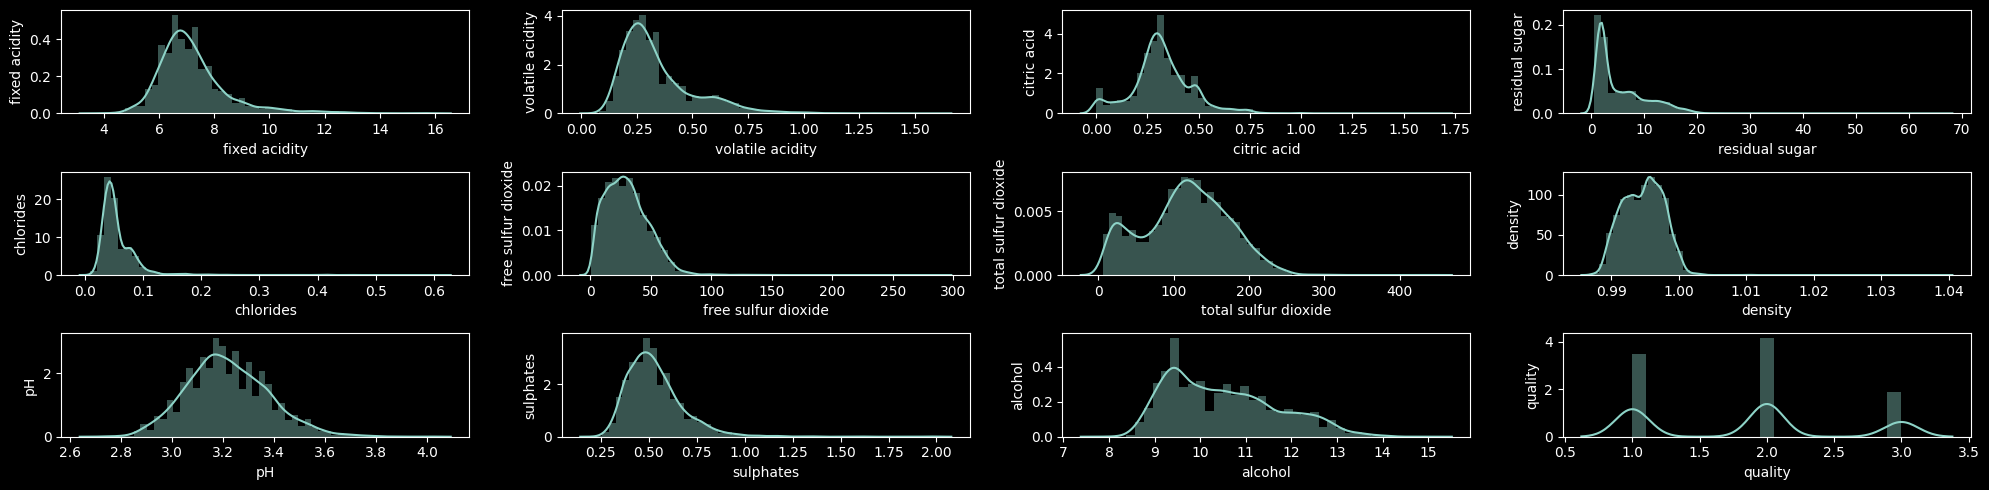

In [10]:
# 전체 데이터 산포 확인
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])

for i in range(0, 12):
  plt.subplot(3, 4, i+1)
  plt.grid(False)
  sns.distplot(df.iloc[:,i])
  plt.ylabel(df.columns[i])

plt.gcf().set_size_inches(20,5)
plt.tight_layout()
plt.show()

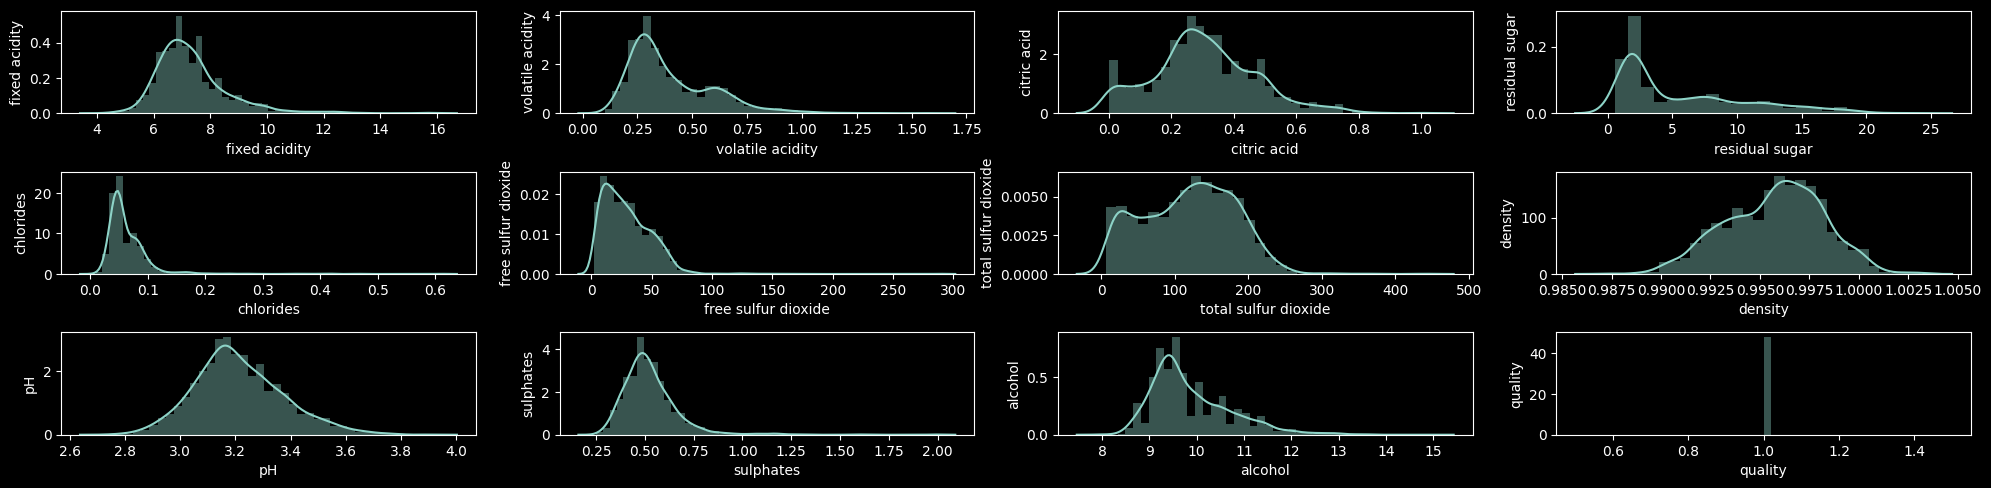

In [11]:
# 품질 1등급 데이터 산포 확인
df1 = df[df['quality']==1]

for i in range(0, 12):
  plt.subplot(3, 4, i+1)
  plt.grid(False)
  sns.distplot(df1.iloc[:,i])
  plt.ylabel(df1.columns[i])

plt.gcf().set_size_inches(20,5)
plt.tight_layout()
plt.show()

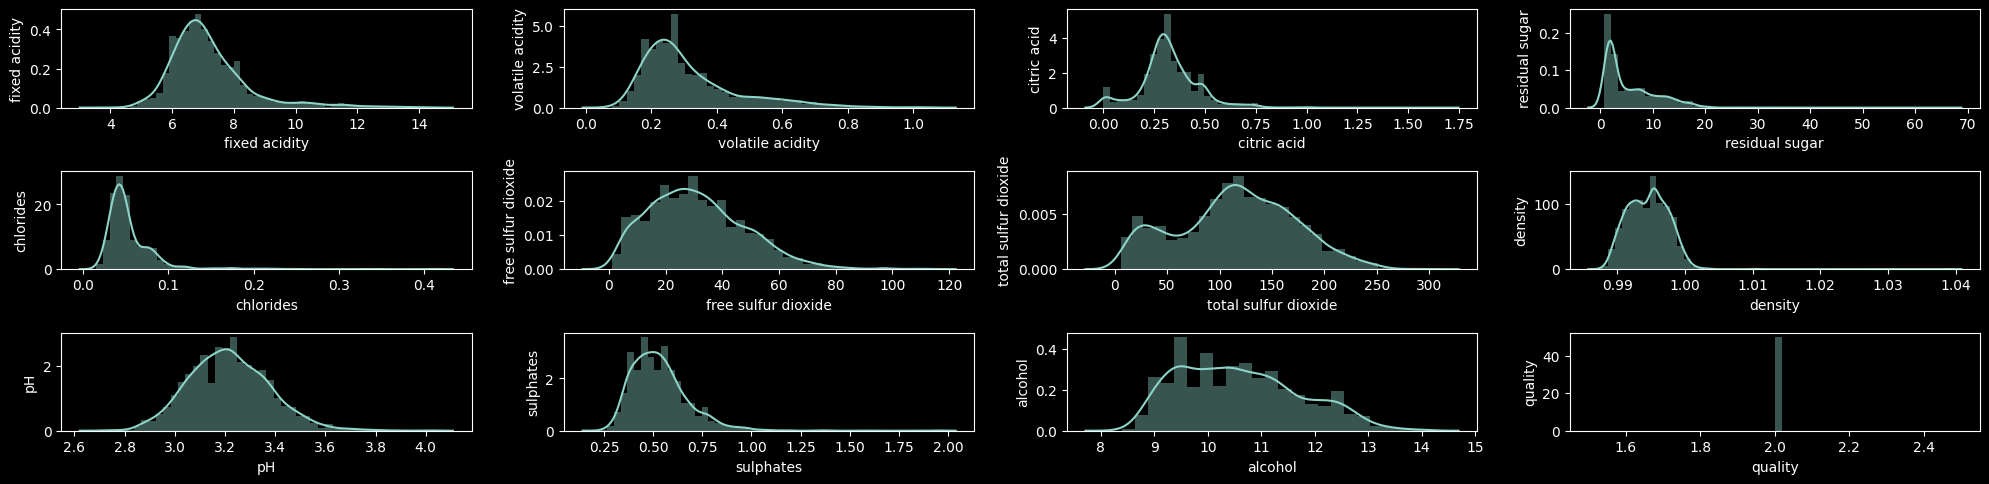

In [12]:
# 품질 2등급 데이터 산포 확인
df2 = df[df['quality']==2]

for i in range(0, 12):
  plt.subplot(3, 4, i+1)
  plt.grid(False)
  sns.distplot(df2.iloc[:,i])
  plt.ylabel(df2.columns[i])

plt.gcf().set_size_inches(20,5)
plt.tight_layout()
plt.show()

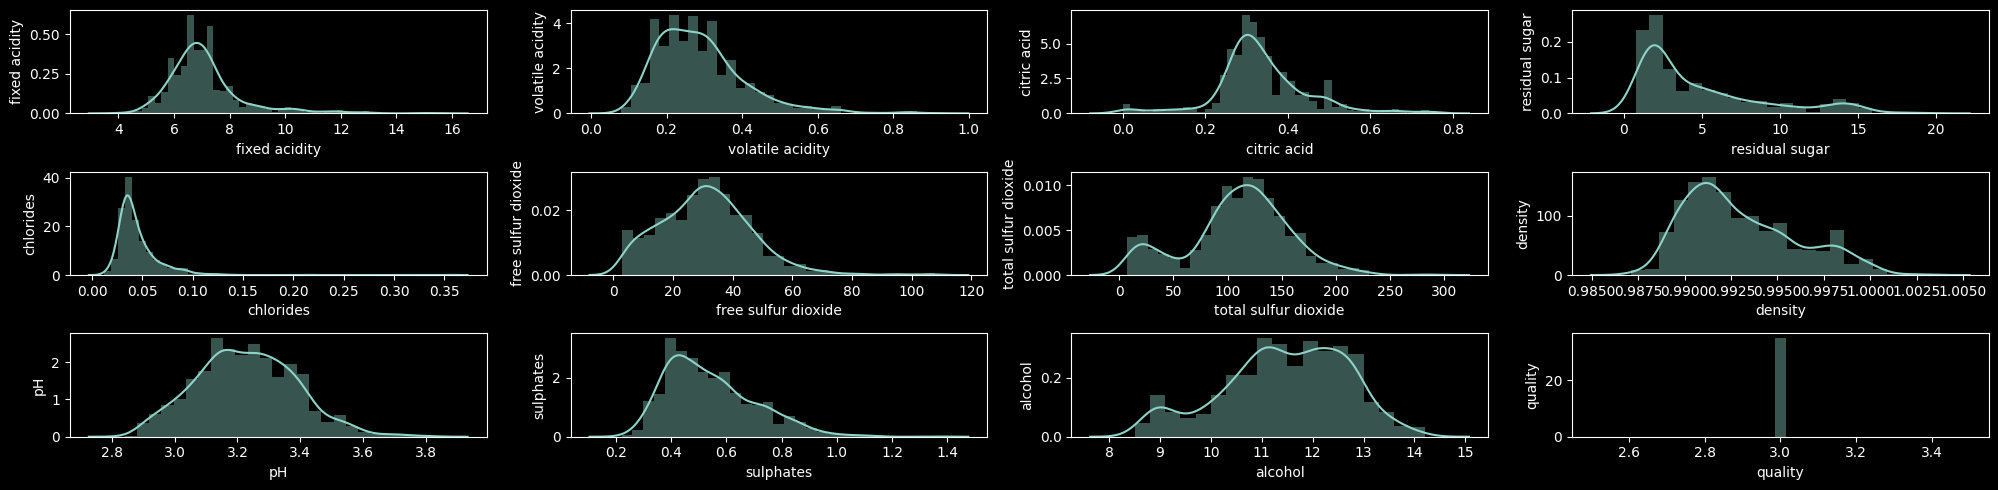

In [13]:
# 품질 3등급 데이터 산포 확인
df3 = df[df['quality']==3]

for i in range(0, 12):
  plt.subplot(3, 4, i+1)
  plt.grid(False)
  sns.distplot(df3.iloc[:,i])
  plt.ylabel(df3.columns[i])

plt.gcf().set_size_inches(20,5)
plt.tight_layout()
plt.show()

## **Session 2**  
## **PCQ를 통한 품질 데이터 Scaling**  

* 같은 Quality group에 속해있는 Wine 상품들은 동일한 Spec으로 생산되어져야 공정능력이 관리된다고 할 수 있음  
* Wine 공정 변수에 Target Spec에서 멀어진(평균과 거리가 떨어진) 정도가 큰 변수일수록 공정관리가 필요한 변수임

### 차원 축소  
---
* Wine Quality data는 index column과 type(red/white)을 제외하고는 12개의 차원으로 이루어진 데이터.   
* 여기서는 그래프로 표현할 수 있는 2차원으로 차원을 축소하여 평균으로부터 멀어진 데이터들을 낮은 품질의 제품으로 판정하고자 함.

In [14]:
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,2
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1


In [15]:
# 품질별 pca 진행 및 설명력 확인
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def pca_feature_var(data, var_ratio):
  roop_ix=data['quality'].unique()

  fig,ax = plt.subplots(len(roop_ix), 1, figsize=(10,10))

  for i,x in enumerate(roop_ix):
    df1=data[(data['quality']==x)]
    X=df1.drop(['quality'],axis=1)

    # Create scaler: scaler
    scaler = StandardScaler()

    # Create PCA instance: pca
    pca = PCA()

    # Create pipeline: pipeline
    pipeline = make_pipeline(scaler, pca)

    # Fit the pipeline to 'samples'
    pipeline.fit(X)
    features = range(pca.n_components_)

    feature_df = pd.DataFrame(data=features, columns=['pc_feature'])
    variance_df = pd.DataFrame(data=pca.explained_variance_ratio_, columns=['variance'])
    pc_feature_df = pd.concat([feature_df, variance_df], axis=1)

    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= var_ratio) + 1
    print('quality:', x, '/ 선택할 차원 수 :', d, '/ 변수 설명력', cumsum[d-1])
    singular_vector = pd.DataFrame(pca.components_.T, index=X.columns)
    print(singular_vector)
    print("-----------")
    sns.barplot(ax=ax[i], x='pc_feature', y='variance', data=pc_feature_df)
    plt.xlabel('PCA feature')
    plt.ylabel('variance')

quality: 1 / 선택할 차원 수 : 2 / 변수 설명력 0.5021112821016065
                            0         1         2         3         4   \
fixed acidity        -0.162490  0.373834  0.443589 -0.318594  0.158819   
volatile acidity     -0.373864  0.185705 -0.278034 -0.169583 -0.121042   
citric acid           0.249655  0.211955  0.508686  0.140954  0.225848   
residual sugar        0.404717  0.212619 -0.195108 -0.227807  0.248177   
chlorides            -0.208530  0.382601  0.002530  0.478848 -0.375295   
free sulfur dioxide   0.424284  0.023057 -0.190288  0.278266  0.063592   
total sulfur dioxide  0.479926 -0.018223 -0.096433  0.232983  0.006013   
density               0.069653  0.566851 -0.229854 -0.290804  0.255879   
pH                   -0.256704 -0.099886 -0.496858  0.117746  0.517767   
sulphates            -0.194687  0.362455  0.012121  0.567605  0.281887   
alcohol              -0.212643 -0.354559  0.289368  0.127910  0.538129   

                            5         6         7        

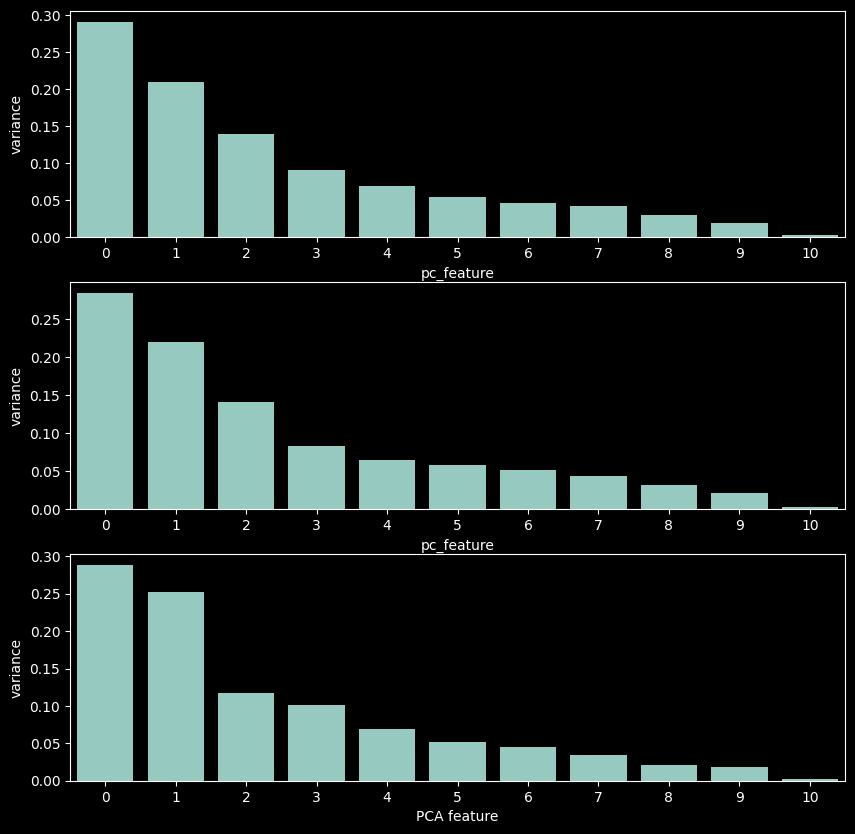

In [16]:
pca_feature_var(df, 0.5)

### 차원축소 Data Plotting
---
* 차원축소된 데이터를 2차원 그래프로 표현

In [17]:
 def pca_plot(df,y) :

       x=df.drop(['quality'], axis=1).reset_index(drop=True)
       y=df[y].reset_index(drop=True)

       X_ = StandardScaler().fit_transform(x)

       pca = PCA(n_components=2)
       pc = pca.fit_transform(X_)

       pc_df=pd.DataFrame(pc,columns=['PC1','PC2']).reset_index(drop=True)
       pc_df=pd.concat([pc_df,y],axis=1)

       plt.rcParams['figure.figsize'] = [5,5]
       sns.scatterplot(data=pc_df,x='PC1',y='PC2',hue=y, legend='brief', s=100, linewidth=0)

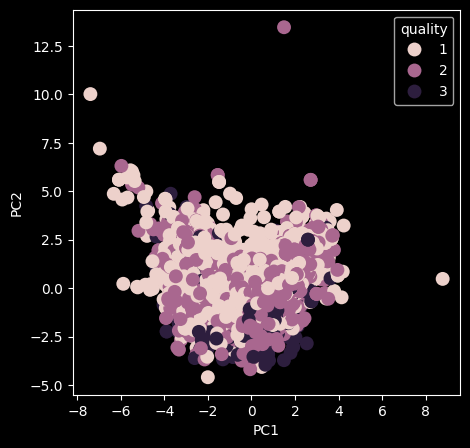

In [18]:
# (0,0) 중심에 모여있는 데이터들은 각 공정변수의 평균과 가까운 데이터
# (0,0) 중심에서 떨어진 데이터일수록 각 공정변수의 평균과 멀어진, 즉 산포가 큰 데이터.

pca_plot(df,'quality')

In [19]:
def pca_plot_prod(data):
    roop_ix=data['quality'].unique()
    fig, ax=plt.subplots(len(roop_ix), 1, figsize=(5,10))

    for i, x in enumerate(roop_ix):
        print("Fig.", i+1, ": ",x)

        df1=data[(data['quality']==x)]
        X=df1.drop(['quality'], axis=1)
        y=df1.quality

        X_ = StandardScaler().fit_transform(X)

        pca = PCA(n_components=2)
        pc = pca.fit_transform(X_)

        pc_df=pd.DataFrame(pc, columns=['PC1','PC2'])

        pc_df['quality']=x

        sns.scatterplot(ax=ax[i], data=pc_df, x='PC1', y='PC2', legend='brief', s=50, linewidth=0)

Fig. 1 :  1
Fig. 2 :  2
Fig. 3 :  3


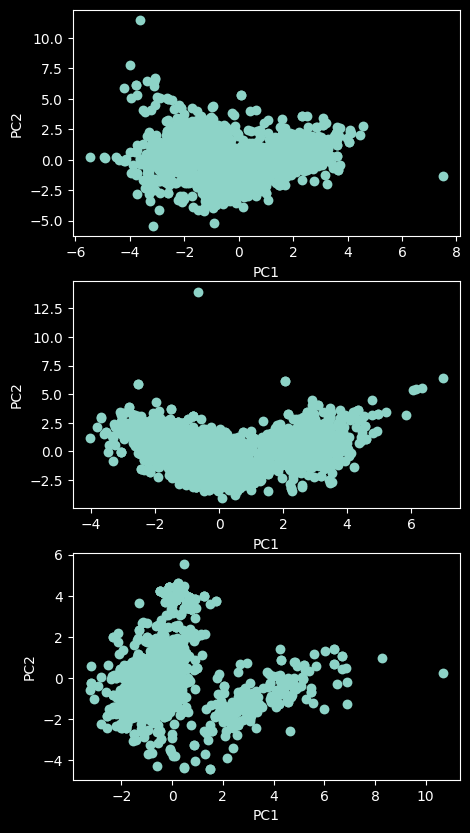

In [20]:
# 품질별 그래프 Plotting
pca_plot_prod(df)

## Session 3
## **품질 등급화**

### 품질 기준 설정
---
* PCA plot 기준 A, B, C 등급 부여

In [21]:
# 품질 등급을 부여하기 위해, PC1값과 PC2값을 기존 데이터에 concat

df1=df[(df['quality']==1)]
X=df1.drop(['quality'], axis=1)
X_ = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pc = pca.fit_transform(X_)

pc_df = pd.DataFrame(pc, columns=['PC1', 'PC2'])

df1_concat = pd.concat([df1.reset_index(drop=True), pc_df], axis=1)

In [22]:
df1_concat.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,PC1,PC2
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,-2.839900,0.446147
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1,-2.541895,1.071394
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1,-2.601232,0.863667
3,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,-2.839900,0.446147
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,1,-2.674377,0.393915


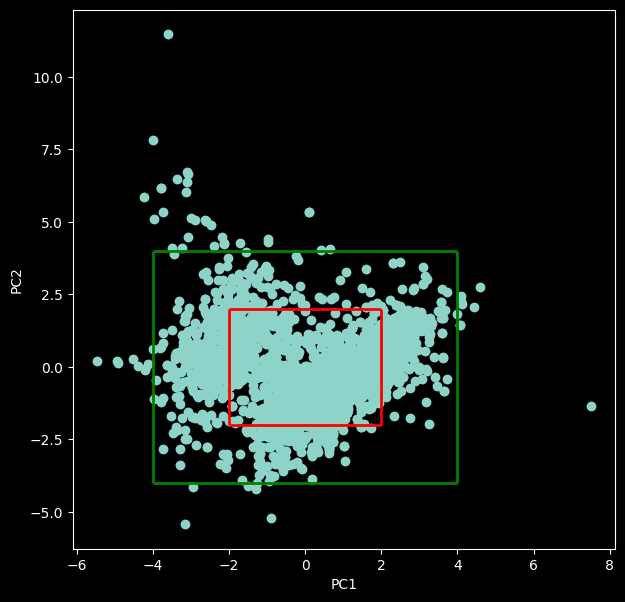

In [24]:
# PC1, PC2인 차원축소 변수 2, -2를 기준으로 등급을 부여
sns.scatterplot(data=df1_concat, x='PC1', y='PC2', s=50, linewidth=0)
# A grade
plt.vlines(-2, ymin=-2, ymax=2, color='r', linewidth=2)
plt.vlines(2, ymin=-2, ymax=2, color='r', linewidth=2)

plt.hlines(-2, xmin=-2, xmax=2, color='r', linewidth=2)
plt.hlines(2, xmin=-2, xmax=2, color='r', linewidth=2)

# B grade
plt.vlines(-4, ymin=-4, ymax=4, color='g', linewidth=2)
plt.vlines(4, ymin=-4, ymax=4, color='g', linewidth=2)

plt.hlines(-4, xmin=-4, xmax=4, color='g', linewidth=2)
plt.hlines(4, xmin=-4, xmax=4, color='g', linewidth=2)

plt.gcf().set_size_inches(7,7)

### 품질 등급 부여
---
* PCA plot 기반 A, B, C 등급 부여

In [25]:
df1_concat.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,PC1,PC2
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,-2.839900,0.446147
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1,-2.541895,1.071394
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1,-2.601232,0.863667
3,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,-2.839900,0.446147
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,1,-2.674377,0.393915


In [27]:
# np.where 활용 if문
df1_concat['grade'] =np.where((df1_concat['PC1']>-2)&(df1_concat['PC1']<2)&(df1_concat['PC2']>-2)&(df1_concat['PC2']<2),'A',
         np.where((df1_concat['PC1']>-4)&(df1_concat['PC1']<4)&(df1_concat['PC2']>-4)&(df1_concat['PC2']<4),'B','C'))

df1_concat.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,PC1,PC2,grade
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,-2.839900,0.446147,B
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1,-2.541895,1.071394,B
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1,-2.601232,0.863667,B
3,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,-2.839900,0.446147,B
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,1,-2.674377,0.393915,B


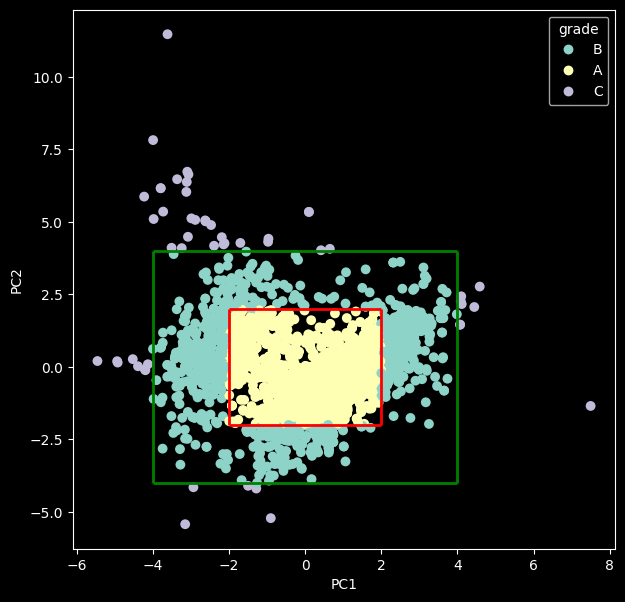

In [28]:
# PC1, PC2인 차원축소 변수 2, -2를 기준으로 등급을 부여
sns.scatterplot(data=df1_concat, x='PC1', y='PC2', s=50, linewidth=0, hue='grade')
# A grade
plt.vlines(-2, ymin=-2, ymax=2, color='r', linewidth=2)
plt.vlines(2, ymin=-2, ymax=2, color='r', linewidth=2)

plt.hlines(-2, xmin=-2, xmax=2, color='r', linewidth=2)
plt.hlines(2, xmin=-2, xmax=2, color='r', linewidth=2)

# B grade
plt.vlines(-4, ymin=-4, ymax=4, color='g', linewidth=2)
plt.vlines(4, ymin=-4, ymax=4, color='g', linewidth=2)

plt.hlines(-4, xmin=-4, xmax=4, color='g', linewidth=2)
plt.hlines(4, xmin=-4, xmax=4, color='g', linewidth=2)

plt.gcf().set_size_inches(7,7)

### 품질 등급에 따른 공정변수 확인
---
* PCA plot 기반 A,B,C 등급 부여

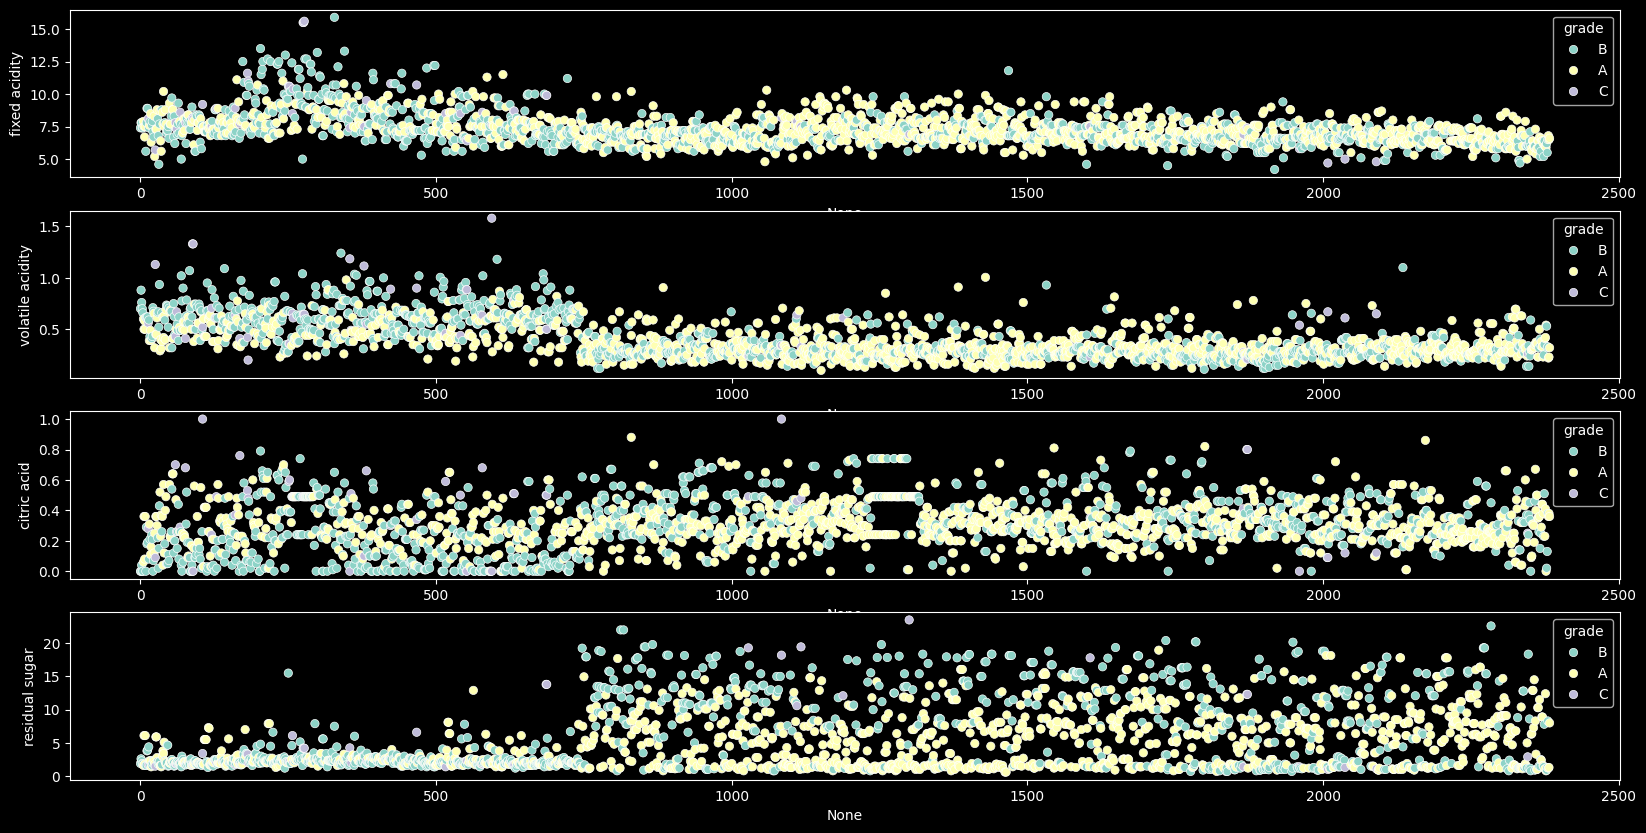

In [29]:
# 1등급의 Wine이라도 C등급은 모든 공정변수 기준으로 평균값에서 멀어지는 경향이 큼.
fig, axes = plt.subplots(4,1)
sns.scatterplot(x=df1_concat.index, y=df1_concat['fixed acidity'], hue=df1_concat['grade'], ax=axes[0])
sns.scatterplot(x=df1_concat.index, y=df1_concat['volatile acidity'], hue=df1_concat['grade'], ax=axes[1])
sns.scatterplot(x=df1_concat.index, y=df1_concat['citric acid'], hue=df1_concat['grade'], ax=axes[2])
sns.scatterplot(x=df1_concat.index, y=df1_concat['residual sugar'], hue=df1_concat['grade'], ax=axes[3])
plt.gcf().set_size_inches(20,10)

In [30]:
# copy
df=df1_concat.copy()

In [31]:
# 모델링을 학습하기 위한 Feature(X)와 Y데이터를 구하는 단계
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X=df.drop(['quality','PC1','PC2','grade'], axis=1)
Y=df['grade']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=Y)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(1668, 11)
(1668,)
(716, 11)
(716,)


In [32]:
# 모델 학습
rfc = RandomForestClassifier(n_estimators=500, max_depth=6, random_state=123456)
rfc.fit(x_train, y_train)

# 예측
y_pred_train = rfc.predict(x_train)
y_pred_test = rfc.predict(x_test)

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           A       0.91      0.99      0.95       938
           B       0.96      0.87      0.91       693
           C       1.00      0.57      0.72        37

    accuracy                           0.93      1668
   macro avg       0.96      0.81      0.86      1668
weighted avg       0.93      0.93      0.93      1668

              precision    recall  f1-score   support

           A       0.83      0.94      0.88       402
           B       0.86      0.75      0.80       298
           C       1.00      0.06      0.12        16

    accuracy                           0.84       716
   macro avg       0.90      0.58      0.60       716
weighted avg       0.85      0.84      0.83       716



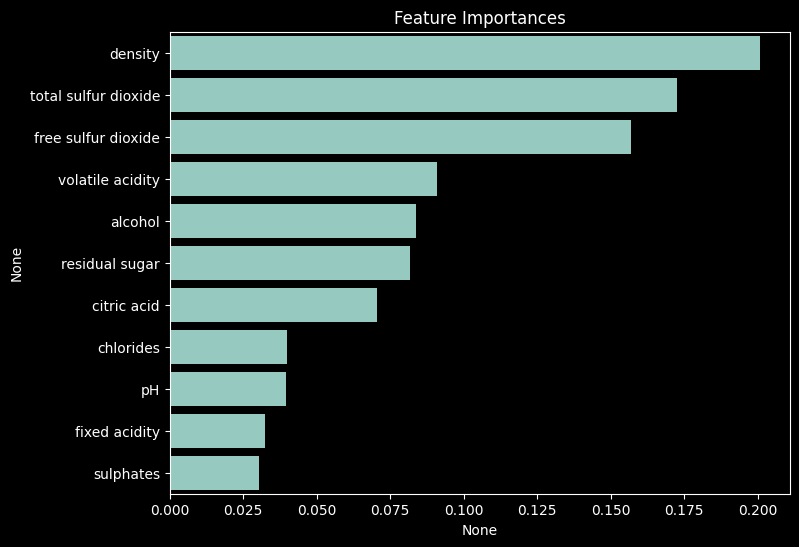

In [33]:
ftr_importances_values = rfc.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()